# Experiments on MobileNetV3Small using transfer learning fine-tune techniques

This is the part 2 of three-part series:
1. `Model selection`
2. `Fine-tuning`
3. `Evaluation`


## Running a series of transfer learning experiments

We will be running following experiments and try to get best possible results:
1. `baseline_model`: This will be the base of our experiments
  * `baseline_model (fine-tune)`: Use fine-tuning transfer learning to train baseline model for longer
2. `class_weights_model`: Initially this model will get weights from `Baseline model` then for further training the class weights will be set to pay more attention to samples from an under-represented class (covid class in our case)
3. `gamma_model`: Train the model on gamma correction images
4. `augmented_model`: Train the model on augmented images (covid only) 

While some of these models will be running on different versions of the traning data, they will be evaluated on the same test dataset, this ensures the results of each experiment are as comparable as possible.

All experiments will be done using the `MobileNetV3Small` model within the `tf.keras.applications` module.

In [4]:
import os
import random
import zipfile
import pathlib
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# TensorFlow
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set the random seeds
os.environ['TF_CUDNN_DETERMINISTIC'] = '1' 
random.seed(hash("setting random seeds") % 2**32 - 1)
np.random.seed(hash("improves reproducibility") % 2**32 - 1)
tf.random.set_seed(hash("by removing stochasticity") % 2**32 - 1)

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
# Unzip data
ref = zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/covid_ready_dataset/covid_radiography_all_data.zip')
ref.extractall()
ref.close()

In [9]:
# Walk through directories
dir_path = "/content/covid_radiography_all_data"

for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '/content/covid_radiography_all_data'.
There are 2 directories and 0 images in '/content/covid_radiography_all_data/test'.
There are 0 directories and 724 images in '/content/covid_radiography_all_data/test/covid'.
There are 0 directories and 2039 images in '/content/covid_radiography_all_data/test/normal'.
There are 2 directories and 0 images in '/content/covid_radiography_all_data/train'.
There are 0 directories and 2892 images in '/content/covid_radiography_all_data/train/covid'.
There are 0 directories and 8153 images in '/content/covid_radiography_all_data/train/normal'.


In [10]:
# Create training and test directories
train_dir = 'covid_radiography_all_data/train'
test_dir = 'covid_radiography_all_data/test'

In [11]:
# Get the class names
data_dir = pathlib.Path(train_dir)
class_names = np.array([item.name for item in data_dir.glob('*')])
print(class_names)

['covid' 'normal']


In [ ]:
# Create function to view a random image
def view_random_image(target_dir, target_class):
  # setup target directory
  target_folder = target_dir + "/" +target_class
  print(target_folder)

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + '/' + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis('off')
  
  if target_class == 'normal':
        print(f'Normal image shape: {img.shape}')  # show the shape of the image
  if target_class == 'covid':
    print(f'Covid image shape: {img.shape}')

  return img

covid_radiography_all_data/train/normal
Normal image shape: (299, 299)
covid_radiography_all_data/train/covid
Covid image shape: (299, 299)


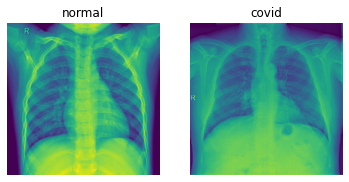

In [ ]:
# View a random images from both classes
plt.figure()
plt.subplot(1, 2, 1)
normal_img = view_random_image(target_dir=train_dir,
                        target_class='normal')
plt.subplot(1, 2, 2)
covid_img = view_random_image(target_dir=train_dir,
                        target_class='covid')

In [12]:
# Create data generator and load in images
IMG_SIZE = (224, 224)

train_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

train_data = train_datagen.flow_from_directory(train_dir,
                                              target_size=IMG_SIZE,
                                              class_mode='binary',
                                              color_mode='rgb')

test_data = test_datagen.flow_from_directory(test_dir,
                                            target_size=IMG_SIZE,
                                            class_mode='binary',
                                            color_mode='rgb')

Found 11045 images belonging to 2 classes.
Found 2763 images belonging to 2 classes.


In [ ]:
# Input shape
input_shape = (224, 224, 3)

# Create backbone model
backbone_model = tf.keras.applications.MobileNetV3Small(include_top=False)
# Freeze the backbone model weights
backbone_model.trainable = False

# Create inputs and output layers
inputs = layers.Input(shape=input_shape, name='input_layer')  # create input layer
x = backbone_model(inputs, training=False) # pass input layer to backbone model but keep it in inference mode, so batchnorm layers don't get updated 
# Average pool the outputs of the base model (aggregate all the most important information, reduce the computation)
x = layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)
# Create the output activation layer
outputs = layers.Dense(1, activation='sigmoid', name='output_layer')(x)

# Combine the inputs with outputs into a model
baseline_model = tf.keras.Model(inputs, outputs)

6709248/6698480 [==============================] - 0s 0us/step


In [ ]:
# Check model summary
baseline_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 MobilenetV3small (Functiona  (None, 1, 1, 1024)       1529968   
 l)                                                              
                                                                 
 global_average_pooling_laye  (None, 1024)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 1)                 1025      
                                                                 
Total params: 1,530,993
Trainable params: 1,025
Non-trainable params: 1,529,968
_________________________________________________________________


## Setting up callbacks

In [ ]:
# Setup checkpoint path
checkpoint_path = 'covid_model_checkpoints_weights/checkpoint.ckpt'

# Create a ModelCheckpoint callback to save the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=True,
                                                         save_freq='epoch',
                                                         monitor='val_accuracy',
                                                         verbose=1)

In [ ]:
# Compile the model
baseline_model.compile(optimizer=tf.keras.optimizers.Adam(),
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

# Fit the model
INITIAL_EPOCHS = 5

baseline_history = baseline_model.fit(train_data,
                                  epochs=INITIAL_EPOCHS,
                                  steps_per_epoch=len(train_data),
                                  validation_data=test_data,
                                  validation_steps=int(0.20*len(test_data)),
                                  callbacks=[checkpoint_callback])

Epoch 1/5
346/346 [==============================] - ETA: 0s - loss: 0.2773 - accuracy: 0.8953
Epoch 00001: val_accuracy improved from -inf to 0.93750, saving model to covid_model_checkpoints_weights/checkpoint.ckpt
346/346 [==============================] - 157s 442ms/step - loss: 0.2773 - accuracy: 0.8953 - val_loss: 0.1808 - val_accuracy: 0.9375
Epoch 2/5
346/346 [==============================] - ETA: 0s - loss: 0.1807 - accuracy: 0.9376
Epoch 00002: val_accuracy improved from 0.93750 to 0.95588, saving model to covid_model_checkpoints_weights/checkpoint.ckpt
346/346 [==============================] - 152s 440ms/step - loss: 0.1807 - accuracy: 0.9376 - val_loss: 0.1396 - val_accuracy: 0.9559
Epoch 3/5
346/346 [==============================] - ETA: 0s - loss: 0.1543 - accuracy: 0.9469
Epoch 00003: val_accuracy did not improve from 0.95588
346/346 [==============================] - 150s 432ms/step - loss: 0.1543 - accuracy: 0.9469 - val_loss: 0.1575 - val_accuracy: 0.9449
Epoch 4/5


In [ ]:
# Evaluate on the test data
baseline_model_results = baseline_model.evaluate(test_data)
baseline_model_results

87/87 [==============================] - 37s 420ms/step - loss: 0.1322 - accuracy: 0.9526


[0.13223588466644287, 0.9525877833366394]

In [ ]:
# Plot model loss curves
def plot_loss_curves(history):
  """
  Args:
    history: Takes model saved history logs
  Returns:
    Separate loss curves for training and validation metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('epochs')
  plt.legend();

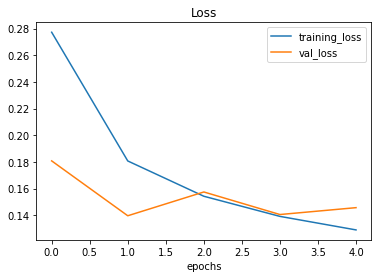

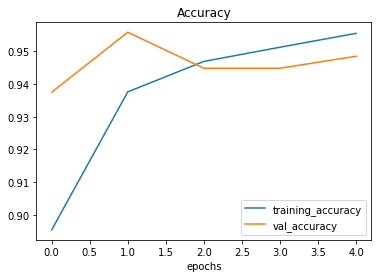

In [ ]:
# Check out our model's training curves
plot_loss_curves(baseline_history)

In [ ]:
# Load back in saved model weights
baseline_model.load_weights(checkpoint_path)

# Evalaute the model on saved weights (accuracy should be same as before)
loaded_baseline_model_results = baseline_model.evaluate(test_data)

87/87 [==============================] - 37s 422ms/step - loss: 0.1688 - accuracy: 0.9403


## Fine-tune baseline model

In [ ]:
# Check model summary
baseline_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 MobilenetV3small (Functiona  (None, 1, 1, 1024)       1529968   
 l)                                                              
                                                                 
 global_average_pooling_laye  (None, 1024)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 1)                 1025      
                                                                 
Total params: 1,530,993
Trainable params: 1,025
Non-trainable params: 1,529,968
_________________________________________________________________


In [ ]:
# Layers in baseline model
baseline_model.layers

In [ ]:
# Trainable layers in baseline model
for layer in baseline_model.layers:
    print(layer.trainable)

True
False
True
True


In [ ]:
# How many trainable variables are in the backbone model
len(backbone_model.trainable_variables)

0

In [ ]:
# Trainable layers in backbone modelv(none)
for layer_num, layer in enumerate(backbone_model.layers):
    print(layer_num, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 Conv False
3 Conv/BatchNorm False
4 tf.__operators__.add False
5 re_lu False
6 tf.math.multiply False
7 multiply False
8 expanded_conv/depthwise/pad False
9 expanded_conv/depthwise False
10 expanded_conv/depthwise/BatchNorm False
11 re_lu_1 False
12 expanded_conv/squeeze_excite/AvgPool False
13 expanded_conv/squeeze_excite/Conv False
14 expanded_conv/squeeze_excite/Relu False
15 expanded_conv/squeeze_excite/Conv_1 False
16 tf.__operators__.add_1 False
17 re_lu_2 False
18 tf.math.multiply_1 False
19 expanded_conv/squeeze_excite/Mul False
20 expanded_conv/project False
21 expanded_conv/project/BatchNorm False
22 expanded_conv_1/expand False
23 expanded_conv_1/expand/BatchNorm False
24 re_lu_3 False
25 expanded_conv_1/depthwise/pad False
26 expanded_conv_1/depthwise False
27 expanded_conv_1/depthwise/BatchNorm False
28 re_lu_4 False
29 expanded_conv_1/project False
30 expanded_conv_1/project/BatchNorm False
31 expanded_conv_2/expand False
32 expanded_co

In [ ]:
# Unfreeze all layers of backbone model
backbone_model.trainable = True

# Freeze all layers of backbone model except for the last 10
for layer in backbone_model.layers[:-10]:
    layer.trainable = False

# Recompile baseline_model
baseline_model.compile(loss='binary_crossentropy',
                       optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # lr is 10x lower than before for fine-tuning
                       metrics=['accuracy'])

In [ ]:
# Check now if the backbone model is trainable (should output true)
backbone_model.trainable

True

In [ ]:
# Check which layers are trainable in backbone model (should be last 10 layers)
for layer_num, layer in enumerate(backbone_model.layers):
    print(layer_num, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 Conv False
3 Conv/BatchNorm False
4 tf.__operators__.add False
5 re_lu False
6 tf.math.multiply False
7 multiply False
8 expanded_conv/depthwise/pad False
9 expanded_conv/depthwise False
10 expanded_conv/depthwise/BatchNorm False
11 re_lu_1 False
12 expanded_conv/squeeze_excite/AvgPool False
13 expanded_conv/squeeze_excite/Conv False
14 expanded_conv/squeeze_excite/Relu False
15 expanded_conv/squeeze_excite/Conv_1 False
16 tf.__operators__.add_1 False
17 re_lu_2 False
18 tf.math.multiply_1 False
19 expanded_conv/squeeze_excite/Mul False
20 expanded_conv/project False
21 expanded_conv/project/BatchNorm False
22 expanded_conv_1/expand False
23 expanded_conv_1/expand/BatchNorm False
24 re_lu_3 False
25 expanded_conv_1/depthwise/pad False
26 expanded_conv_1/depthwise False
27 expanded_conv_1/depthwise/BatchNorm False
28 re_lu_4 False
29 expanded_conv_1/project False
30 expanded_conv_1/project/BatchNorm False
31 expanded_conv_2/expand False
32 expanded_co

In [ ]:
# Fine tune for another 5 epochs
fine_tune_epochs = INITIAL_EPOCHS + 5

# Refit the model (same as earlier except with more trainable layers in backbone model)
baseline_fine_tune_history = baseline_model.fit(train_data,
                                                epochs=fine_tune_epochs,
                                                validation_data=test_data,
                                                initial_epoch=baseline_history.epoch[-1], # start from previous last epoch
                                                validation_steps=int(0.20*len(test_data)))

Epoch 5/10
346/346 [==============================] - 160s 453ms/step - loss: 0.1407 - accuracy: 0.9515 - val_loss: 0.0988 - val_accuracy: 0.9669
Epoch 6/10
346/346 [==============================] - 156s 452ms/step - loss: 0.1115 - accuracy: 0.9606 - val_loss: 0.1314 - val_accuracy: 0.9559
Epoch 7/10
346/346 [==============================] - 158s 457ms/step - loss: 0.0920 - accuracy: 0.9706 - val_loss: 0.1013 - val_accuracy: 0.9688
Epoch 8/10
346/346 [==============================] - 158s 456ms/step - loss: 0.0810 - accuracy: 0.9729 - val_loss: 0.1046 - val_accuracy: 0.9577
Epoch 9/10
346/346 [==============================] - 159s 458ms/step - loss: 0.0747 - accuracy: 0.9762 - val_loss: 0.0665 - val_accuracy: 0.9743
Epoch 10/10
346/346 [==============================] - 158s 455ms/step - loss: 0.0673 - accuracy: 0.9785 - val_loss: 0.0765 - val_accuracy: 0.9743


In [ ]:
# Evaluate the model on the test data
baseline_fine_tune_results = baseline_model.evaluate(test_data)

87/87 [==============================] - 37s 427ms/step - loss: 0.0883 - accuracy: 0.9678


In [ ]:
def compare_histories(original_history, new_history, INITIAL_EPOCHS=5):
    """
    Compares two model history objects.
    """
    # Get original history measurements
    acc = original_history.history['accuracy']
    loss = original_history.history['loss']
    print(len(acc))
    
    val_acc = original_history.history['val_accuracy']
    val_loss = original_history.history['val_loss']
    
    # Combine original history with new history
    total_acc = acc + new_history.history['accuracy']
    total_loss = loss + new_history.history['loss']
    
    total_val_acc = val_acc + new_history.history['val_accuracy']
    total_val_loss = val_loss + new_history.history['val_loss']
    
    print(len(total_acc))
    print(total_acc)
    
    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([INITIAL_EPOCHS-1, INITIAL_EPOCHS-1],
            plt.ylim(), label='Start Fine Tuning')  # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    
    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([INITIAL_EPOCHS-1, INITIAL_EPOCHS-1],
            plt.ylim(), label='Start Fine Tuning')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

5
11
[0.8953372836112976, 0.9376188516616821, 0.9469442963600159, 0.9512901902198792, 0.9555454850196838, 0.9514712691307068, 0.9606156349182129, 0.9705749154090881, 0.9729289412498474, 0.9761883020401001, 0.9784517884254456]


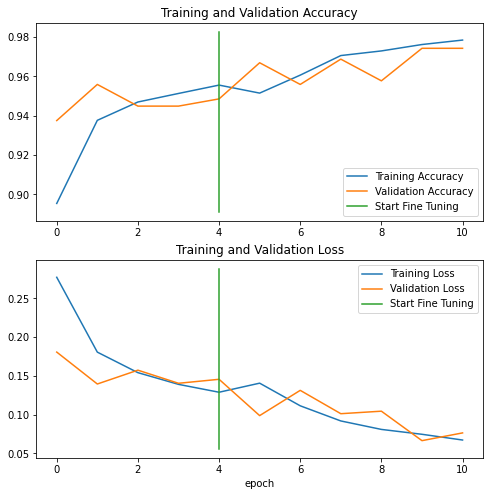

In [ ]:
compare_histories(original_history=baseline_history,
                 new_history=baseline_fine_tune_history)

## Class Weights

In [ ]:
# Give more weights to lesser class
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(train_data.classes),
                                                 train_data.classes)
class_weights = dict(enumerate(class_weights))

# Check how much weights each class has got
class_weights

{0: 1.9095781466113417, 1: 0.6773580277198578}

In [13]:
train_data.classes

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [ ]:
# Check the class indices
train_data.class_indices

{'covid': 0, 'normal': 1}

In [ ]:
# Build new model to apply class weights during training
# Input shape
input_shape = (224, 224, 3)

# Create backbone model
backbone_model = tf.keras.applications.MobileNetV3Small(include_top=False)
backbone_model.trainable = False

# Create inputs and output layers
inputs = layers.Input(shape=input_shape, name='input_layer')
x = backbone_model(inputs, training=False)
x = layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)
outputs = layers.Dense(1, activation='sigmoid', name='output_layer')(x)

# Combine the inputs with outputs into a model
class_weights_model = tf.keras.Model(inputs, outputs)

In [ ]:
# Check summary
class_weights_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 MobilenetV3small (Functiona  (None, 1, 1, 1024)       1529968   
 l)                                                              
                                                                 
 global_average_pooling_laye  (None, 1024)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 1)                 1025      
                                                                 
Total params: 1,530,993
Trainable params: 1,025
Non-trainable params: 1,529,968
_________________________________________________________________


In [ ]:
# Check which layers are tuneable in the whole model
for layer_number, layer in enumerate(class_weights_model.layers):
    print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 MobilenetV3small False
2 global_average_pooling_layer True
3 output_layer True


In [ ]:
# Make backbone model trainable
backbone_model.trainable = True

# Freeze all layers except for last 10 (same as before)
for layer in backbone_model.layers[:-10]:
    layer.trainable = False

In [ ]:
# Check layers
for layer_num, layer in enumerate(backbone_model.layers):
    print(layer_num, layer.name, layer.trainable)

0 input_2 False
1 rescaling_1 False
2 Conv False
3 Conv/BatchNorm False
4 tf.__operators__.add_28 False
5 re_lu_33 False
6 tf.math.multiply_28 False
7 multiply_19 False
8 expanded_conv/depthwise/pad False
9 expanded_conv/depthwise False
10 expanded_conv/depthwise/BatchNorm False
11 re_lu_34 False
12 expanded_conv/squeeze_excite/AvgPool False
13 expanded_conv/squeeze_excite/Conv False
14 expanded_conv/squeeze_excite/Relu False
15 expanded_conv/squeeze_excite/Conv_1 False
16 tf.__operators__.add_29 False
17 re_lu_35 False
18 tf.math.multiply_29 False
19 expanded_conv/squeeze_excite/Mul False
20 expanded_conv/project False
21 expanded_conv/project/BatchNorm False
22 expanded_conv_1/expand False
23 expanded_conv_1/expand/BatchNorm False
24 re_lu_36 False
25 expanded_conv_1/depthwise/pad False
26 expanded_conv_1/depthwise False
27 expanded_conv_1/depthwise/BatchNorm False
28 re_lu_37 False
29 expanded_conv_1/project False
30 expanded_conv_1/project/BatchNorm False
31 expanded_conv_2/expand 

In [ ]:
# Load and use weights of baseline model checkpoint
class_weights_model.load_weights(checkpoint_path)

# Compile
class_weights_model.compile(loss='binary_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                           metrics=['accuracy'])

In [ ]:
# Fine tune baseline model with class weights for another 5 epochs
fine_tune_epochs = INITIAL_EPOCHS + 5

# Fit the class_weights_model
class_weights_history = class_weights_model.fit(train_data,
                                                epochs=fine_tune_epochs,
                                                validation_data=test_data,
                                                initial_epoch=baseline_history.epoch[-1],
                                                validation_steps=int(0.20*len(test_data)),
                                                class_weight=class_weights)  ## add weights

Epoch 5/10
346/346 [==============================] - 161s 454ms/step - loss: 0.2164 - accuracy: 0.9229 - val_loss: 0.1195 - val_accuracy: 0.9559
Epoch 6/10
346/346 [==============================] - 155s 447ms/step - loss: 0.0914 - accuracy: 0.9696 - val_loss: 0.0887 - val_accuracy: 0.9743
Epoch 7/10
346/346 [==============================] - 156s 449ms/step - loss: 0.0715 - accuracy: 0.9750 - val_loss: 0.0765 - val_accuracy: 0.9724
Epoch 8/10
346/346 [==============================] - 153s 442ms/step - loss: 0.0520 - accuracy: 0.9813 - val_loss: 0.1140 - val_accuracy: 0.9559
Epoch 9/10
346/346 [==============================] - 154s 443ms/step - loss: 0.0434 - accuracy: 0.9842 - val_loss: 0.0866 - val_accuracy: 0.9761
Epoch 10/10
346/346 [==============================] - 153s 443ms/step - loss: 0.0359 - accuracy: 0.9874 - val_loss: 0.0652 - val_accuracy: 0.9706


In [ ]:
# Evaluate the model
class_weights_results = class_weights_model.evaluate(test_data)

87/87 [==============================] - 36s 412ms/step - loss: 0.0834 - accuracy: 0.9710


5
11
[0.8953372836112976, 0.9376188516616821, 0.9469442963600159, 0.9512901902198792, 0.9555454850196838, 0.9228610396385193, 0.9695789813995361, 0.9750112891197205, 0.9813490509986877, 0.9842462539672852, 0.9874151349067688]


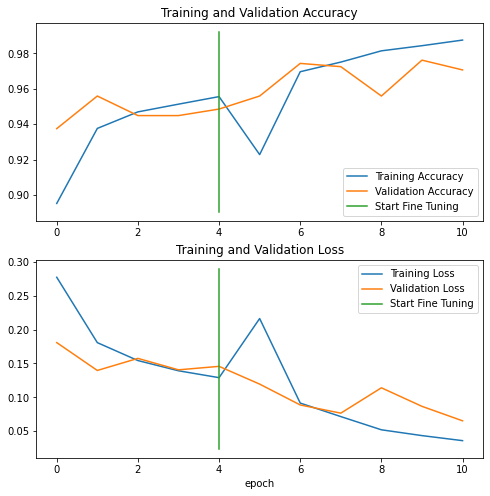

In [ ]:
# How did fine-tuning go with class weights
compare_histories(original_history=baseline_history,
                 new_history=class_weights_history)

## Gamma Correction

![](https://pyimagesearch.com/wp-content/uploads/2015/09/gamma_correction_example.jpg)

*The effect of gamma correction on an image.*

For the purpose of this we will have to import gamma preprocessed data for training.

In [ ]:
# Unzip directory where the data is located
ref = zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/covid_ready_dataset/covid_radiography_all_data_gamma.zip')
ref.extractall()
ref.close()

covid_radiography_all_data_gamma/train/normal
Normal image shape: (299, 299)
covid_radiography_all_data_gamma/train/covid
Covid image shape: (299, 299)


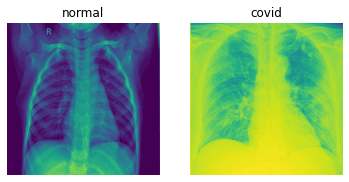

In [ ]:
# Create training directory
train_dir_gamma = 'covid_radiography_all_data_gamma/train'

# View a random images from both classes
plt.figure()
plt.subplot(1, 2, 1)
normal_img = view_random_image(target_dir=train_dir_gamma,
                        target_class='normal')
plt.subplot(1, 2, 2)
covid_img = view_random_image(target_dir=train_dir_gamma,
                        target_class='covid')


In [ ]:
train_data_gamma = train_datagen.flow_from_directory(train_dir_gamma,
                                                    target_size=IMG_SIZE,
                                                    class_mode='binary',
                                                    color_mode='rgb')

Found 11045 images belonging to 2 classes.


In [ ]:
# Build model and apply gamma correction
# Input shape
input_shape = (224, 224, 3)

# Create backbone model
backbone_model = tf.keras.applications.MobileNetV3Small(include_top=False)
backbone_model.trainable = False

# Create inputs and output layers
inputs = layers.Input(shape=input_shape, name='input_layer')
x = backbone_model(inputs, training=False)
x = layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)
outputs = layers.Dense(1, activation='sigmoid', name='output_layer')(x)

# Combine the inputs with outputs into a model
gamma_correction_model = tf.keras.Model(inputs, outputs)

# Compile
gamma_correction_model.compile(loss='binary_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

In [ ]:
# Fit the gamma_correction_model
gamma_correction_history = gamma_correction_model.fit(train_data_gamma,  # training on gamma correction images
                                                      epochs=10,  # train for same epochs as baseline model in total
                                                      steps_per_epoch=len(train_data_gamma),
                                                      validation_data=test_data,
                                                      validation_steps=int(0.20*len(test_data)))

Epoch 1/10
346/346 [==============================] - 151s 428ms/step - loss: 0.1249 - accuracy: 0.9616 - val_loss: 0.9672 - val_accuracy: 0.5294
Epoch 2/10
346/346 [==============================] - 146s 423ms/step - loss: 0.0295 - accuracy: 0.9948 - val_loss: 1.5213 - val_accuracy: 0.4173
Epoch 3/10
346/346 [==============================] - 144s 417ms/step - loss: 0.0174 - accuracy: 0.9966 - val_loss: 1.6354 - val_accuracy: 0.4375
Epoch 4/10
346/346 [==============================] - 144s 417ms/step - loss: 0.0122 - accuracy: 0.9975 - val_loss: 1.5293 - val_accuracy: 0.4669
Epoch 5/10
346/346 [==============================] - 144s 415ms/step - loss: 0.0093 - accuracy: 0.9983 - val_loss: 1.9993 - val_accuracy: 0.4099
Epoch 6/10
346/346 [==============================] - 144s 415ms/step - loss: 0.0074 - accuracy: 0.9988 - val_loss: 2.0034 - val_accuracy: 0.4099
Epoch 7/10
346/346 [==============================] - 143s 412ms/step - loss: 0.0062 - accuracy: 0.9989 - val_loss: 2.1444 -

In [ ]:
# Evaluate the model
gamma_correction_results = gamma_correction_model.evaluate(test_data)

87/87 [==============================] - 35s 402ms/step - loss: 2.5715 - accuracy: 0.3829


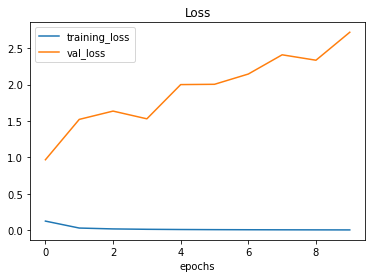

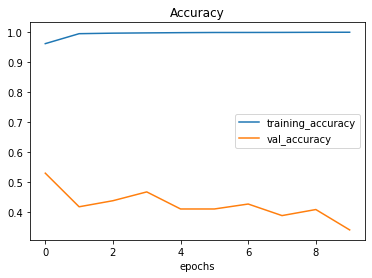

In [ ]:
# Check out training curves
plot_loss_curves(gamma_correction_history)

## Data augmentation (covid only)

Again we will have to import augmented preprocessed data.

In [ ]:
# Unzip directory
ref = zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/covid_ready_dataset/covid_radiography_all_data_augmented.zip')
ref.extractall()
ref.close()

covid_radiography_all_data_augmented/train/normal
Normal image shape: (299, 299)
covid_radiography_all_data_augmented/train/covid
Covid image shape: (299, 299)


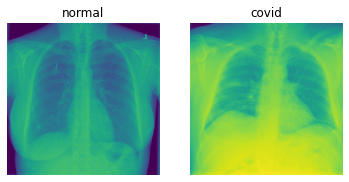

In [ ]:
# Set training path with augmented covid images
train_dir_aug = 'covid_radiography_all_data_augmented/train'

# View a random images from both classes (only covid images are augmented)
plt.figure()
plt.subplot(1, 2, 1)
normal_img = view_random_image(target_dir=train_dir_aug,
                        target_class='normal')
plt.subplot(1, 2, 2)
covid_img = view_random_image(target_dir=train_dir_aug,
                        target_class='covid')

In [ ]:
# Load in training data
train_data_aug = train_datagen.flow_from_directory(train_dir_aug,
                                                   target_size=IMG_SIZE,
                                                   class_mode='binary',
                                                   color_mode='rgb')

Found 13937 images belonging to 2 classes.


In [ ]:
# Build model and apply image augmentation
# Input shape
input_shape = (224, 224, 3)

# Create backbone model
backbone_model = tf.keras.applications.MobileNetV3Small(include_top=False)
backbone_model.trainable = False

# Create inputs and output layers
inputs = layers.Input(shape=input_shape, name='input_layer')
x = backbone_model(inputs, training=False)
x = layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)
outputs = layers.Dense(1, activation='sigmoid', name='output_layer')(x)

# Combine the inputs with outputs into a model
augmented_model = tf.keras.Model(inputs, outputs)

# Compile
augmented_model.compile(loss='binary_crossentropy',
                        optimizer=tf.keras.optimizers.Adam(),
                        metrics=['accuracy'])

In [ ]:
# Fit the augmented_model
augmented_history = augmented_model.fit(train_data_aug,  # training on augmented images
                                        epochs=10,  # same number of epochs as baseline model
                                        steps_per_epoch=len(train_data_gamma),
                                        validation_data=test_data,
                                        validation_steps=int(0.20*len(test_data)))

Epoch 1/10
346/346 [==============================] - 158s 445ms/step - loss: 0.2070 - accuracy: 0.9243 - val_loss: 0.2758 - val_accuracy: 0.8915
Epoch 2/10
346/346 [==============================] - 154s 445ms/step - loss: 0.1090 - accuracy: 0.9647 - val_loss: 0.2049 - val_accuracy: 0.9228
Epoch 3/10
346/346 [==============================] - 153s 443ms/step - loss: 0.0894 - accuracy: 0.9706 - val_loss: 0.1730 - val_accuracy: 0.9375
Epoch 4/10
346/346 [==============================] - 153s 441ms/step - loss: 0.0784 - accuracy: 0.9751 - val_loss: 0.2120 - val_accuracy: 0.9265
Epoch 5/10
346/346 [==============================] - 153s 441ms/step - loss: 0.0672 - accuracy: 0.9788 - val_loss: 0.1622 - val_accuracy: 0.9412
Epoch 6/10
346/346 [==============================] - 149s 431ms/step - loss: 0.0668 - accuracy: 0.9790 - val_loss: 0.2069 - val_accuracy: 0.9228
Epoch 7/10
346/346 [==============================] - 146s 420ms/step - loss: 0.0586 - accuracy: 0.9820 - val_loss: 0.1840 -

In [ ]:
# Evaluate the model
augmented_results = augmented_model.evaluate(test_data)

87/87 [==============================] - 35s 403ms/step - loss: 0.1899 - accuracy: 0.9298


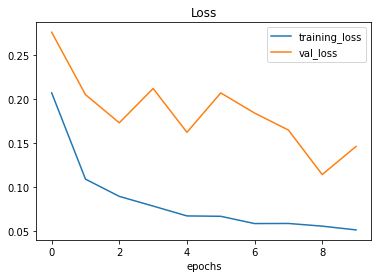

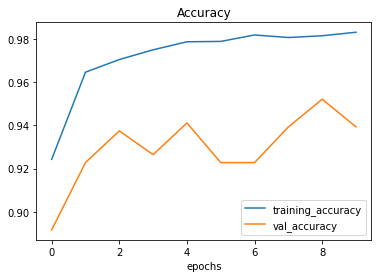

In [ ]:
# Check out training curves
plot_loss_curves(augmented_history)

## Performance comparison

In [ ]:
# Create a list of model results
model_results = [['baseline_model', baseline_model_results],
                 ['baseline_model', baseline_fine_tune_results],
                 ['class_weights_model', class_weights_results],
                 ['gamma_correction_model', gamma_correction_results],
                 ['augmented_model', augmented_results]]

all_results = pd.DataFrame(model_results, columns=['model', 'loss-accuracy'])
all_results

,model,loss-accuracy
0,baseline_model,"[0.13223588466644287, 0.9525877833366394]"
1,baseline_model,"[0.08832783252000809, 0.9677886366844177]"
2,class_weights_model,"[0.08335953950881958, 0.971045970916748]"
3,gamma_correction_model,"[2.5715420246124268, 0.3829171061515808]"
4,augmented_model,"[0.18992099165916443, 0.9297864437103271]"
